In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import gc
from datetime import datetime
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from tensorflow.keras.applications import mobilenet_v2
import shap
import tensorflow.experimental.numpy as tnp
import warnings
import random
warnings.filterwarnings('ignore')
shap.initjs()
tnp.experimental_enable_numpy_behavior()

# pandasの表示を設定
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
class CFG:

    model_name = 'MobileNetV2'

    resize_dimension = 224

    batch_size = 8
    
    epochs = 20

    folds = 4

    fine_tune_at = 151

    seed = 123

    img_size = [224, 224]

    augment   = True

    transform_prob = 1.0
    fill_mode = 'constant'
    rot    = 3.0
    shr    = 6.0
    hzoom  = 80.0
    wzoom  = 80.0
    hshift = 30.0
    wshift = 30.0

    hflip = True
    vflip = True

    p_pixel_aug = 0.90
    cont = [0.7, 1.8]
    bri  = 0.3

    clip = False

    drop_prob   = 1.0
    drop_cnt    = 30
    drop_size   = 0.08

    target_col  = ['kidney_injury']

### Seeding

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')

seeding(CFG.seed)

seeding done!!!


In [4]:
df_kidney = pd.read_csv('./Dataset/kidney/kidney.csv')

### Assign fold numbers

In [5]:
df_kidney['stratify'] = ''

for col in CFG.target_col:
    df_kidney['stratify'] += df_kidney[col].astype(str)

df_kidney = df_kidney.reset_index(drop=True)

sgkf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(sgkf.split(df_kidney, df_kidney['stratify'], df_kidney['patient_id'])):
    df_kidney.loc[val_idx, 'fold'] = fold

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)



def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)



# make affine transformation matrix
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):

    # degrees to radians
    shear = math.pi * shear / 180.


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))



# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    shear        = CFG.shr * tf.random.normal([1], dtype='float32')
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 3])  

    return image



# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    return image



# apply mixup amd cutmix to image
# mixup
def get_mixup(alpha, prob):
    
    
    @tf.function
    def mixup(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        images = lamb * images + (1.0 - lamb) * tf.roll(images, shift=1, axis=0)
        labels = lamb * labels + (1.0 - lamb) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels
    
    return mixup



# cutmix
def get_cutmix(alpha, prob):


    @tf.function
    def cutmix(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        width = tf.cast(image_shape[2], tf.int32)
        height = tf.cast(image_shape[1], tf.int32)

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        r_x = random_int([], minval=0, maxval=width)
        r_y = random_int([], minval=0, maxval=height)
        r = 0.5 * tf.math.sqrt(1.0 - lamb)
        r_w_half = tf.cast(r * tf.cast(width, tf.float32), tf.int32)
        r_h_half = tf.cast(r * tf.cast(height, tf.float32), tf.int32)

        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, width), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, width), tf.int32)
        y1 = tf.cast(tf.clip_by_value(r_y - r_h_half, 0, height), tf.int32)
        y2 = tf.cast(tf.clip_by_value(r_y + r_h_half, 0, height), tf.int32)

        # outer-pad patch -> [0, 0, 1, 1, 0, 0]
        patch1 = images[:, y1:y2, x1:x2, :]  # [batch, height, width, channel]
        patch1 = tf.pad(patch1, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])  # outer-pad

        # inner-pad patch -> [1, 1, 0, 0, 1, 1]
        patch2 = tf.roll(images, shift=1, axis=0)[:, y1:y2, x1:x2, :]
        patch2 = tf.pad(patch2, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])
        patch2 = tf.roll(images, shift=1, axis=0) - patch2  # inner-pad = img - outer-pad

        images = patch1 + patch2  # cutmix img

        lambda2 = tf.cast((1.0 - (x2 - x1) * (y2 - y1) / (width * height)), tf.float32)
        labels = lambda2 * labels + (1.0 - lambda2) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels

    return cutmix

### Data pipeline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [7]:
def build_decoder(with_labels=True, target_size=CFG.img_size):


    def decode_image(path):

        file_binary = tf.io.read_file(path)
        image = tf.image.decode_png(file_binary, channels=3, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.img_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*CFG.img_size, 3])

        return image
    

    def decode_label(label):
        
        label = tf.cast(label, tf.float32)
        
        return(label[0:1])
    
    def decode_with_labels(path, label):

        return decode_image(path), decode_label(label)

    return decode_with_labels if with_labels else decode_image
    


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform_prob:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image

        if random_float() < CFG.p_pixel_aug:
            image = tf.image.random_contrast(image, CFG.cont[0], CFG.cont[1])
            image = tf.image.random_brightness(image, CFG.bri)
        
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(image, [*DIM, 3])

        return image

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment



def build_dataset(paths, labels=None, batch_size=CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=False, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != '' and cache is True:
        os.makedirs('./cache_dir', exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds0 = tf.data.Dataset.from_tensor_slices(slices)
    ds0 = ds0.map(decode_fn, num_parallel_calls=AUTO)
    ds0 = ds0.cache(cache_dir) if cache else ds0
    ds0 = ds0.repeat() if repeat else ds0

    ds0_size = tf.data.experimental.cardinality(ds0).numpy()
    
    ds1 = ds0.take(ds0_size)
    ds2 = ds0.take(ds0_size)

    ds1 = ds1.map(augment_fn, num_parallel_calls=AUTO) if augment else ds1

    if augment and labels is not None:
        ds1 = ds1.map(lambda image, label: (dropout(image,
                                                DIM=CFG.img_size, 
                                                PROBABILITY=CFG.drop_prob, 
                                                cutout=CFG.drop_cnt,
                                                size=CFG.drop_size), label),num_parallel_calls=AUTO)
    
    ds = ds1.concatenate(ds2)
    
    ds = ds.shuffle(shuffle, seed=CFG.seed)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    ds = ds.prefetch(AUTO)

    return ds

### Build Model

In [8]:
def build_model(model_name=CFG.model_name, dim=CFG.img_size):

        # backbone
        base = getattr(mobilenet_v2, model_name)(include_top=False, input_shape=(*dim, 3), weights='imagenet', pooling='avg')
        base.trainable = True
        print(f'Number of layers in base: {len(base.layers)}')
        print(f'Fine tuning from layer {CFG.fine_tune_at}')

        for layer in base.layers[:CFG.fine_tune_at]:
                layer.trainable = False


        inp = base.inputs

        x = base.output
        #x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # necks
        x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)

        # heads
        out_kidney = tf.keras.layers.Dense(1, name='kidney', activation='sigmoid')(x_kidney)

        out = [out_kidney]

        model = tf.keras.Model(inputs=inp, outputs=out)


        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
        loss = {'kidney':tf.keras.losses.BinaryCrossentropy()}
        metrics = {'kidney':'accuracy'}
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


        return model


### Training

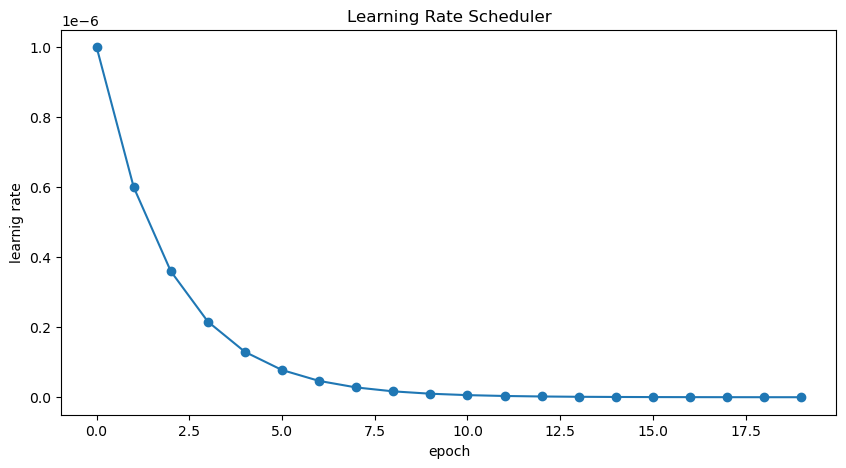

In [9]:
def get_lr_callback(batch_size=8, plot=False):

    initial_lr = 1e-6
   
    def lrfn(epoch):

        lr = initial_lr * 0.60 ** epoch

        return lr
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        #plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(CFG.batch_size, plot=True)

In [10]:
os.makedirs('./mobilenetV2_ckpt/kidneyn/', exist_ok=True)

dic_val_losses = {}

for fold in np.arange(CFG.folds):

    train_df = df_kidney.query("fold!=@fold")
    valid_df = df_kidney.query("fold==@fold")

    train_paths  = train_df.image_path.values
    train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths  = valid_df.image_path.values
    valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    #test_paths   = test_df.image_path.values

    K.clear_session()

    model = build_model(CFG.model_name, dim=CFG.img_size)

    train_ds = build_dataset(train_paths, train_labels)
    valid_ds = build_dataset(valid_paths, valid_labels)

    ## save best model after each fold
    save = tf.keras.callbacks.ModelCheckpoint('./mobilenetV2_ckpt/kidney/fold-%i.h5'%fold, monitor='val_accuracy', 
                                              verbose=1, save_best_only=True,
                                              save_weights_only=False, mode='max', save_freq='epoch')
    
    logs='./logs/mobilenetV2/kidney/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, update_freq='epoch')
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=True)
    
    callbacks_list = []
    callbacks_list.append(save)
    callbacks_list.append(get_lr_callback(CFG.batch_size))
    callbacks_list.append(tensorboard_callback)
    callbacks_list.append(earlystopping_callback)

    history = model.fit(train_ds, validation_data = valid_ds, 
                        epochs=CFG.epochs, steps_per_epoch=None, 
                        callbacks = callbacks_list, max_queue_size=1, verbose=1)
                        
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc = history.history['val_accuracy'][best_epoch]

    print(f'FOLD {fold} RESULTS')
    print(f'BEST Loss  : {best_loss:.3f}\nBEST Acc   : {best_acc:.3f}\nBEST Epoch : {best_epoch}')

    dic_val_losses[fold] = best_loss

K.clear_session()
gc.collect()


2024-01-01 21:17:21.021220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-01 21:17:21.021238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-01-01 21:17:21.021242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-01-01 21:17:21.021270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-01 21:17:21.021284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Number of layers in base: 155
Fine tuning from layer 151
Epoch 1/20


2024-01-01 21:17:25.871411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32195/32195 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.6307
Epoch 1: val_accuracy improved from -inf to 0.53295, saving model to ./mobilenetV2_ckpt/kidney/fold-0.h5
32195/32195 [==============================] - 1501s 47ms/step - loss: 0.6400 - accuracy: 0.6307 - val_loss: 0.7291 - val_accuracy: 0.5330 - lr: 1.0000e-06
Epoch 2/20
32195/32195 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6405
Epoch 2: val_accuracy improved from 0.53295 to 0.56111, saving model to ./mobilenetV2_ckpt/kidney/fold-0.h5
32195/32195 [==============================] - 1614s 50ms/step - loss: 0.6291 - accuracy: 0.6405 - val_loss: 0.7011 - val_accuracy: 0.5611 - lr: 6.0000e-07
Epoch 3/20
32195/32195 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6392
Epoch 3: val_accuracy improved from 0.56111 to 0.57003, saving model to ./mobilenetV2_ckpt/kidney/fold-0.h5
32195/32195 [==============================] - 1538s 48ms/step - loss: 0.6278 

83042

In [9]:
test_df = pd.read_csv('./Dataset/test/test.csv')

In [10]:
CKPT_DIRS = [ (CFG.img_size, './mobilenetV2_ckpt/kidney/'),]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.folds]
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[224, 224],
  ['./mobilenetV2_ckpt/kidney/fold-0.h5',
   './mobilenetV2_ckpt/kidney/fold-1.h5',
   './mobilenetV2_ckpt/kidney/fold-2.h5',
   './mobilenetV2_ckpt/kidney/fold-3.h5']]]

In [11]:
def post_proc(pred):
    proc_pred = np.empty(2*1, dtype='float32')

    proc_pred[0] = 1 - pred[0] # kidney-healthy
    proc_pred[1] = pred[0] # kidney-injured

    return proc_pred


patient_ids = test_df['patient_id'].unique()

patient_ids.sort()

patient_preds = np.zeros(shape=(len(patient_ids), 2), dtype='float32')

preds = np.zeros(shape=(1, 1), dtype=np.float32)

for pidx, patient_id in tqdm(enumerate(patient_ids)):

    patient_df = test_df[test_df['patient_id'] == patient_id]

    test_paths   = patient_df.image_path.values

    test_ds = build_dataset(test_paths, augment=False)

    model_preds = np.zeros(shape=(1, 1), dtype=np.float32)

    print(f'Patient ID: {patient_id}')

    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):

        patient_images = patient_df.image_path.tolist()

        min_batchsize = len(patient_images)
        CFG.batch_size = min(min_batchsize, CFG.batch_size)

        dtest = build_dataset(patient_images, batch_size=CFG.batch_size, cache=False,
                                   decode_fn=build_decoder(with_labels=False, target_size=CFG.img_size))
        
        for fold_path in fold_paths:

            model = tf.keras.models.load_model(fold_path, compile=False)
    
            pred5 = model.predict(dtest, verbose=1)
            pred4 = np.concatenate(pred5, axis=-1).astype('float32')
            pred3 = pred4[:len(patient_images)]
            pred2 = np.mean(pred3.reshape(1, len(patient_images), 1), axis=0)
            pred = np.max(pred2, axis=0) # taking max prediction of all ct scans for a patient
        
            model_preds += pred / (len(fold_paths))
                            
            del model
            K.clear_session()
            gc.collect()
        
        del dtest, patient_images
        K.clear_session()
        gc.collect()

    patient_preds[pidx, :] += post_proc(pred)

    del model_preds
    K.clear_session()
    gc.collect()


0it [00:00, ?it/s]2024-01-02 12:13:40.089187: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-02 12:13:40.089213: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-01-02 12:13:40.089217: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-01-02 12:13:40.089513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-02 12:13:40.089549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Patient ID: 521


2024-01-02 12:13:42.306282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 25ms/step


1it [00:15, 15.10s/it]

Patient ID: 1705
177/177 [==============================] - 5s 22ms/step


2it [00:39, 20.65s/it]

Patient ID: 1902
84/84 [==============================] - 3s 21ms/step


3it [00:56, 18.72s/it]

Patient ID: 2770
195/195 [==============================] - 5s 22ms/step


4it [01:22, 21.92s/it]

Patient ID: 3685
69/69 [==============================] - 3s 28ms/step


5it [01:40, 20.31s/it]

Patient ID: 4852
251/251 [==============================] - 7s 22ms/step


6it [02:13, 24.85s/it]

Patient ID: 5817
259/259 [==============================] - 7s 23ms/step


7it [02:49, 28.36s/it]

Patient ID: 6545
237/237 [==============================] - 7s 24ms/step


8it [03:24, 30.42s/it]

Patient ID: 7115
57/57 [==============================] - 3s 23ms/step


9it [03:42, 26.55s/it]

Patient ID: 7437
156/156 [==============================] - 5s 26ms/step


10it [04:11, 27.45s/it]

Patient ID: 8371
204/204 [==============================] - 6s 21ms/step


11it [04:43, 28.62s/it]

Patient ID: 11130
167/167 [==============================] - 6s 26ms/step


12it [05:15, 29.76s/it]

Patient ID: 11633
211/211 [==============================] - 7s 25ms/step


13it [05:53, 32.19s/it]

Patient ID: 11793
214/214 [==============================] - 7s 25ms/step


14it [06:31, 33.87s/it]

Patient ID: 11886
150/150 [==============================] - 4s 21ms/step


15it [06:59, 32.22s/it]

Patient ID: 12086
113/113 [==============================] - 6s 32ms/step


16it [07:30, 31.75s/it]

Patient ID: 12893
59/59 [==============================] - 5s 47ms/step


17it [07:57, 30.35s/it]

Patient ID: 14102
312/312 [==============================] - 10s 26ms/step


18it [08:46, 36.05s/it]

Patient ID: 15226
316/316 [==============================] - 10s 24ms/step


19it [09:36, 40.35s/it]

Patient ID: 15385
155/155 [==============================] - 7s 31ms/step


20it [10:14, 39.65s/it]

Patient ID: 16691
522/522 [==============================] - 18s 30ms/step


21it [11:36, 52.09s/it]

Patient ID: 17439
183/183 [==============================] - 6s 23ms/step


22it [12:14, 48.15s/it]

Patient ID: 18407
233/233 [==============================] - 8s 29ms/step


23it [13:04, 48.57s/it]

Patient ID: 19054
185/185 [==============================] - 7s 22ms/step


24it [13:44, 46.08s/it]

Patient ID: 19914
143/143 [==============================] - 6s 33ms/step


25it [14:26, 44.74s/it]

Patient ID: 21471
227/227 [==============================] - 7s 22ms/step


26it [15:08, 44.01s/it]

Patient ID: 21518
171/171 [==============================] - 6s 23ms/step


27it [15:48, 42.80s/it]

Patient ID: 21821
177/177 [==============================] - 6s 23ms/step


28it [16:31, 42.72s/it]

Patient ID: 22103
165/165 [==============================] - 7s 29ms/step


29it [17:16, 43.34s/it]

Patient ID: 22639
189/189 [==============================] - 6s 26ms/step


30it [18:03, 44.55s/it]

Patient ID: 23885
86/86 [==============================] - 5s 24ms/step


31it [18:37, 41.52s/it]

Patient ID: 23979
127/127 [==============================] - 7s 35ms/step


32it [19:22, 42.54s/it]

Patient ID: 25173
227/227 [==============================] - 8s 25ms/step


33it [20:14, 45.40s/it]

Patient ID: 25294
206/206 [==============================] - 10s 31ms/step


34it [21:10, 48.44s/it]

Patient ID: 25922
307/307 [==============================] - 15s 33ms/step


35it [22:20, 55.05s/it]

Patient ID: 26598
161/161 [==============================] - 11s 42ms/step


36it [23:18, 55.87s/it]

Patient ID: 27421
183/183 [==============================] - 11s 41ms/step


37it [24:21, 58.09s/it]

Patient ID: 27428
67/67 [==============================] - 9s 74ms/step


38it [25:18, 57.77s/it]

Patient ID: 27701
268/268 [==============================] - 13s 30ms/step


39it [26:35, 63.34s/it]

Patient ID: 28123
227/227 [==============================] - 10s 26ms/step


40it [27:37, 63.05s/it]

Patient ID: 28144
68/68 [==============================] - 9s 82ms/step


41it [28:30, 60.14s/it]

Patient ID: 29539
175/175 [==============================] - 12s 47ms/step


42it [29:35, 61.38s/it]

Patient ID: 30396
300/300 [==============================] - 14s 30ms/step


43it [31:03, 69.34s/it]

Patient ID: 30613
324/324 [==============================] - 17s 36ms/step


44it [32:39, 77.59s/it]

Patient ID: 31034
164/164 [==============================] - 12s 39ms/step


45it [34:01, 78.62s/it]

Patient ID: 31842
176/176 [==============================] - 15s 52ms/step


46it [35:28, 81.22s/it]

Patient ID: 31927
380/380 [==============================] - 19s 37ms/step


47it [37:13, 88.50s/it]

Patient ID: 32943
229/229 [==============================] - 16s 43ms/step


48it [38:51, 91.26s/it]

Patient ID: 33007
213/213 [==============================] - 14s 37ms/step


49it [40:25, 92.23s/it]

Patient ID: 33182
253/253 [==============================] - 13s 28ms/step


50it [41:56, 91.57s/it]

Patient ID: 35187
293/293 [==============================] - 19s 41ms/step


51it [43:43, 96.39s/it]

Patient ID: 35383
201/201 [==============================] - 10s 31ms/step


52it [45:04, 91.63s/it]

Patient ID: 35473
178/178 [==============================] - 12s 53ms/step


53it [46:27, 89.11s/it]

Patient ID: 36091
166/166 [==============================] - 10s 28ms/step


54it [47:40, 84.17s/it]

Patient ID: 36576
298/298 [==============================] - 17s 36ms/step


55it [49:15, 87.65s/it]

Patient ID: 37095
67/67 [==============================] - 8s 72ms/step


56it [50:32, 84.45s/it]

Patient ID: 37169
124/124 [==============================] - 14s 78ms/step


57it [52:00, 85.31s/it]

Patient ID: 37597
176/176 [==============================] - 10s 39ms/step


58it [53:25, 85.22s/it]

Patient ID: 37748
171/171 [==============================] - 16s 57ms/step


59it [55:02, 88.79s/it]

Patient ID: 38059
74/74 [==============================] - 19s 156ms/step


60it [56:43, 92.67s/it]

Patient ID: 38882
75/75 [==============================] - 9s 75ms/step


61it [58:15, 92.42s/it]

Patient ID: 40451
151/151 [==============================] - 16s 83ms/step


62it [59:52, 93.65s/it]

Patient ID: 40792
144/144 [==============================] - 15s 83ms/step


63it [1:01:32, 95.55s/it]

Patient ID: 41364
327/327 [==============================] - 20s 33ms/step


64it [1:03:27, 101.41s/it]

Patient ID: 43381
159/159 [==============================] - 15s 36ms/step


65it [1:04:59, 98.51s/it] 

Patient ID: 43565
40/40 [==============================] - 11s 69ms/step


66it [1:06:17, 92.40s/it]

Patient ID: 44620
62/62 [==============================] - 16s 202ms/step


67it [1:08:00, 95.78s/it]

Patient ID: 46419
196/196 [==============================] - 15s 50ms/step


68it [1:09:52, 100.40s/it]

Patient ID: 47333
65/65 [==============================] - 16s 175ms/step


69it [1:11:29, 99.60s/it] 

Patient ID: 48384
89/89 [==============================] - 19s 115ms/step


70it [1:13:19, 102.64s/it]

Patient ID: 49261
172/172 [==============================] - 15s 54ms/step


71it [1:15:09, 104.75s/it]

Patient ID: 49814
312/312 [==============================] - 28s 55ms/step


72it [1:17:29, 115.34s/it]

Patient ID: 50296
248/248 [==============================] - 17s 31ms/step


73it [1:19:19, 113.67s/it]

Patient ID: 51026
238/238 [==============================] - 14s 38ms/step


74it [1:21:02, 110.44s/it]

Patient ID: 51927
69/69 [==============================] - 14s 120ms/step


75it [1:22:51, 110.02s/it]

Patient ID: 52160
341/341 [==============================] - 28s 50ms/step


76it [1:25:16, 120.67s/it]

Patient ID: 52783
583/583 [==============================] - 31s 36ms/step


77it [1:28:01, 133.99s/it]

Patient ID: 52813
103/103 [==============================] - 11s 44ms/step


78it [1:29:33, 121.34s/it]

Patient ID: 52827
270/270 [==============================] - 20s 49ms/step


79it [1:31:52, 126.73s/it]

Patient ID: 53819
173/173 [==============================] - 18s 64ms/step


80it [1:34:01, 127.42s/it]

Patient ID: 54285
182/182 [==============================] - 24s 84ms/step


81it [1:36:17, 130.04s/it]

Patient ID: 54817
290/290 [==============================] - 26s 55ms/step


82it [1:38:46, 135.63s/it]

Patient ID: 56527
178/178 [==============================] - 18s 43ms/step


83it [1:40:42, 129.78s/it]

Patient ID: 57034
197/197 [==============================] - 25s 73ms/step


84it [1:43:05, 133.76s/it]

Patient ID: 57087
200/200 [==============================] - 25s 80ms/step


85it [1:45:30, 137.19s/it]

Patient ID: 59262
193/193 [==============================] - 26s 76ms/step


86it [1:47:52, 138.56s/it]

Patient ID: 60009
191/191 [==============================] - 24s 88ms/step


87it [1:50:34, 145.43s/it]

Patient ID: 60472
22/22 [==============================] - 13s 143ms/step


88it [1:52:30, 136.64s/it]

Patient ID: 60619
153/153 [==============================] - 28s 102ms/step


89it [1:55:16, 145.56s/it]

Patient ID: 61547
283/283 [==============================] - 29s 67ms/step


90it [1:58:11, 154.30s/it]

Patient ID: 62066
168/168 [==============================] - 24s 83ms/step


91it [2:00:56, 157.52s/it]

Patient ID: 62397
211/211 [==============================] - 29s 76ms/step


92it [2:03:53, 163.33s/it]

Patient ID: 62763
82/82 [==============================] - 27s 182ms/step


93it [2:06:42, 165.17s/it]

Patient ID: 62847
334/334 [==============================] - 32s 63ms/step


94it [2:09:54, 173.13s/it]

Patient ID: 63957
298/298 [==============================] - 31s 61ms/step


95it [2:13:02, 177.55s/it]

Patient ID: 64594
298/298 [==============================] - 30s 61ms/step


96it [2:16:10, 180.71s/it]

Patient ID: 65289
74/74 [==============================] - 26s 208ms/step


97it [2:18:59, 85.98s/it] 


In [12]:
answer_df = pd.read_csv('./Dataset/test/answer.csv')

In [13]:
pred_kidney = pd.DataFrame({'patient_id':patient_ids,})

for i, row in enumerate(patient_preds):
    pred_kidney.loc[i, 'kidney_healthy'] = row[0]
    pred_kidney.loc[i, 'kidney_injury'] = row[1]

pred_df = pred_kidney.sort_values('patient_id')

Kidney thresholds:
[       inf 0.99312395 0.99287659 0.97978538 0.97686666 0.97593021
 0.97439361 0.9710958  0.97024453 0.96769005 0.96662247 0.96482497
 0.96180773 0.9610182  0.95672959 0.95575213 0.95566666 0.95337582
 0.95235592 0.95224392 0.95130819 0.95087868 0.94982088 0.9495542
 0.94793516 0.94768155 0.94762909 0.94595915 0.9452219  0.9435457
 0.94138795 0.94088018 0.94010347 0.9391315  0.9390372  0.9384169
 0.93720698 0.93629587 0.9342258  0.93421263 0.93401849 0.93341613
 0.93336236 0.93194348 0.93133044 0.93096602 0.92936742 0.92754853
 0.9265554  0.92582154 0.92504239 0.9241637  0.92371702 0.92368346
 0.92142791 0.91995221 0.91936582 0.91851836 0.91846359 0.91829526
 0.91649747 0.91615254 0.91451418 0.91309655 0.90998852 0.90673107
 0.90600502 0.90599251 0.90528452 0.90413791 0.90390921 0.90364766
 0.90177745 0.89701921 0.8968302  0.89558387 0.89461422 0.8937946
 0.89103663 0.8908698  0.88739765 0.88665873 0.88485861 0.88095039
 0.87999916 0.87675661 0.87150848 0.87005621 0.

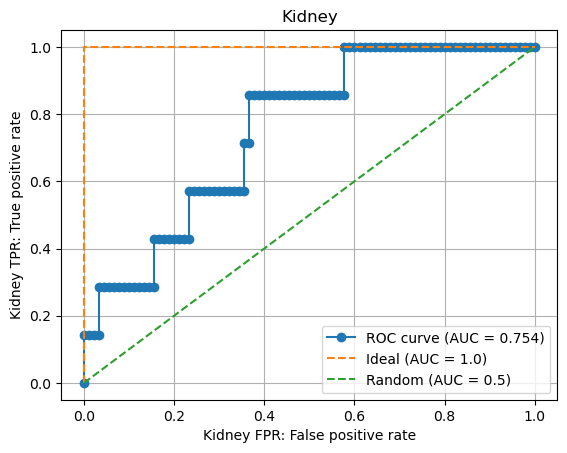

In [14]:
kidney_pred = pred_kidney['kidney_injury'].to_list()
kidney_ans = answer_df['kidney_injury'].to_list()
kidney_roc = roc(kidney_ans, kidney_pred, drop_intermediate=False)
kidney_roc_fpr, kidney_roc_tpr, kidney_roc_thresholds = kidney_roc

plt.plot(kidney_roc_fpr, kidney_roc_tpr, marker='o', label='ROC curve (AUC = %0.3f)' % auroc(kidney_ans, kidney_pred))
plt.plot([0,0,1], [0,1,1], linestyle='--', label='Ideal (AUC = 1.0)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('Kidney FPR: False positive rate')
plt.ylabel('Kidney TPR: True positive rate')
plt.legend()
plt.title('Kidney')
plt.grid()
plt.show

print(f'Kidney thresholds:\n{kidney_roc_thresholds}')

Kidney thresholds:
[0.82110661 0.82870209 0.83080673 0.84193587 0.84252274 0.84492993
 0.84808654 0.85306805 0.86462015 0.86961818 0.87005621 0.87150848
 0.87675661 0.87999916 0.88095039 0.88485861 0.88665873 0.88739765
 0.8908698  0.89103663 0.8937946  0.89461422 0.89558387 0.8968302
 0.89701921 0.90177745 0.90364766 0.90390921 0.90413791 0.90528452
 0.90599251 0.90600502 0.90673107 0.90998852 0.91309655 0.91451418
 0.91615254 0.91649747 0.91829526 0.91846359 0.91851836 0.91936582
 0.91995221 0.92142791 0.92368346 0.92371702 0.9241637  0.92504239
 0.92582154 0.9265554  0.92754853 0.92936742 0.93096602 0.93133044
 0.93194348 0.93336236 0.93341613 0.93401849 0.93421263 0.9342258
 0.93629587 0.93720698 0.9384169  0.9390372  0.9391315  0.94010347
 0.94088018 0.94138795 0.9435457  0.9452219  0.94595915 0.94762909
 0.94768155 0.94793516 0.9495542  0.94982088 0.95087868 0.95130819
 0.95224392 0.95235592 0.95337582 0.95566666 0.95575213 0.95672959
 0.9610182  0.96180773 0.96482497 0.96662247 

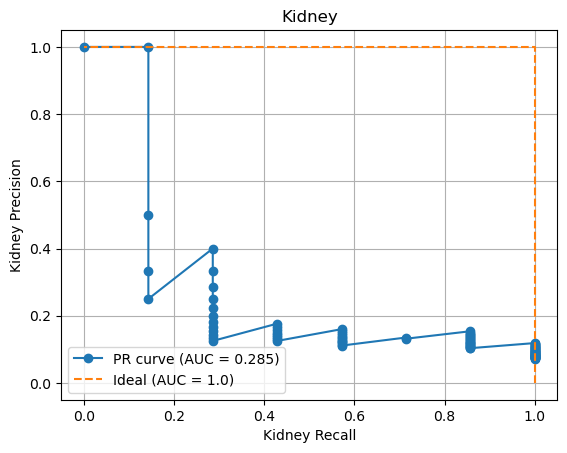

In [15]:
kidney_prc = prc(kidney_ans, kidney_pred, drop_intermediate=False)
kidney_prc_precision, kidney_prc_recall, kidney_prc_thresholds = kidney_prc

plt.plot(kidney_prc_recall, kidney_prc_precision, marker='o', label='PR curve (AUC = %0.3f)' % auc(kidney_prc_recall, kidney_prc_precision))
plt.plot([1,1,0], [0,1,1], linestyle='--', label='Ideal (AUC = 1.0)')
plt.xlabel('Kidney Recall')
plt.ylabel('Kidney Precision')
plt.legend()
plt.title('Kidney')
plt.grid()
plt.show

print(f'Kidney thresholds:\n{kidney_prc_thresholds}')

In [16]:
def to_one_hot(feature, thresholds):

    organ = feature.split('_')[0]
    pred_df = f'pred_{organ}'
    name1 = f'prediction_{feature}'
    globals()[name1] = globals()[pred_df][feature].to_list()
    name3 = f'one_hot_{feature}'
    globals()[name3] = {}

    for t in thresholds:
        name2 = f'one_hot_{feature}_{str(t)}'
        globals()[name2] = globals()[name1].copy()

        for i, v in enumerate(globals()[name2]):
            if t == float('inf'):
                globals()[name2][i] = 0
            elif v >= t:
                globals()[name2][i] = 1
            elif v < t:
                globals()[name2][i] = 0
        
        globals()[name3][t] = globals()[name2]

    return globals()[name3]

In [17]:
one_hot_kidney_injury = to_one_hot('kidney_injury', kidney_roc_thresholds)


l_kidney = []

for key, value in one_hot_kidney_injury.items():

    if recall(kidney_ans, value) == 1.0:
        l_kidney.append(key)

best_threshold_kidney = max(l_kidney)


print('TN FP\nFN TP')

print('\n')

print('Kidney confusion matrix:')
print(cm(kidney_ans, one_hot_kidney_injury[best_threshold_kidney]))
print(f'Kidney accuracy: {accuracy(kidney_ans, one_hot_kidney_injury[best_threshold_kidney])}')

TN FP
FN TP


Kidney confusion matrix:
[[38 52]
 [ 0  7]]
Kidney accuracy: 0.4639175257731959


layer 147, lr 1e-6, 0.60: AUC:0.69, ACC:0.34<br>
layer 151, lr 1e-6, 0.60: AUC:0.75, ACC:0.46<br>